In [1]:
import matplotlib
import numpy as np

import pandas as pd
from scipy.optimize import curve_fit


In [2]:
matplotlib.use('nbAgg')

In [3]:
import matplotlib.pyplot

In [4]:
import matplotlib.pyplot as mpl

In [5]:
kb = 8.62e-5 #boltzmann constant, eV/K
#hbar = 6.58e-16 #reduced Plank constant, in eV.s
hbar = 1.0545718e-34 # Planck constant, J.s
e = 1.60e-19 #electron charge in C
m = 9.11e-31 #electron mass in kg
RK = 1/(e/hbar/(2*np.pi)) #von Kiltzing constant = e^2/h

def deriv (y, x, yaxis=0, xaxis=0): #finite central difference derivative -- first order; y is of type ndarray 
    diff = np.roll (y,1,axis=yaxis) - np.roll (y,-1,axis=yaxis)
    dx = np.roll (x,1,axis=xaxis)  - np.roll (x,-1,axis=xaxis)
    return diff/(dx)

In [6]:
fpath = '2018-05-09_16-05-06.csv'

In [7]:
fpathbase = './'
fpathsplit = (fpathbase , fpath)
fpathcat = fpathbase + fpath

rdata = np.loadtxt (fpathcat,skiprows=1, dtype=float, delimiter=',')
pfdata = pd.read_csv(fpathcat)

pfdata.head()

,Time (s),Dummy,temp (K),Field (kG),Voltage (V),phase
0,0.000000,0.0,1.439,-5.0,0.000346,-2.232
1,0.432117,0.0,1.439,-5.0,0.000346,-2.232
2,0.819559,0.0,1.439,-5.0,0.000346,-2.238
3,1.269074,0.0,1.439,-5.0,0.000346,-2.238
4,1.618685,0.0,1.439,-5.0,0.000346,-2.238


In [8]:
num_loops = 1 #number of nested loops -- i.e. the number of parameters that are being swept in the experiment.
loop_indices = [4] #indices of columns of the looping elements. 

# the next lines insure that the raw data is 'square', i.e. not missing a line or data point

basic_shape = [len((rdata[:,c])) for c in loop_indices] # use CAUTIOUSLY if you do have duplicate data

unique_length = 1
for x in basic_shape:
    unique_length = unique_length*x

rshape = rdata.shape
num_rows = rshape [0]
num_cols = rshape [1]
if unique_length != num_rows:
    raise ValueError('Shape mismatch: Number of rows in raw data is %d, '%num_rows \
                     +'but looping over elements in columns  %s '%str(loop_indices) \
                     +'generates %d many unique elements'%unique_length) 

# format the data into a tensor with many 'dimensions' each of which represents one looping element
tensor_shape = list(basic_shape)
tensor_shape.append (num_cols)
data_fmt = rdata.reshape (tensor_shape)

In [9]:
# TODO: autogenerate this code -- it's messy.
# What are the indices of the quantities of interest
b_index = 3
#g_index = 0
v_index = 4
#i_index = 5
vbias_index = 1

# What are the conversion factors for the quantities of interest.
# Format them such that x * x_conv gives a quantity in SI units.

b_conv = 1.0 / 10 # kG to T
#g_conv = 2
v_conv = 1e6 # gain etc of the equipment, to V
#i_conv = 1 # gain etc of the equipment, to A
#vbias_conv = 22.0/272000

In [10]:
b_field = data_fmt[...,b_index]*b_conv
#gate = data_fmt[...,g_index]*g_conv
#current = data_fmt[...,i_index]*i_conv
voltage = data_fmt[...,v_index]*v_conv
#vbias = data_fmt[...,vbias_index]*vbias_conv

# In a DC experiment, differentiate voltage w/r/t current to get resistance.
#v_bias_axis = num_loops - 1 # the axis, in the 
# variables 'current' and 'voltage', along which v_bias is being swept
#res = deriv (voltage, current, yaxis=v_bias_axis, xaxis=v_bias_axis) #resistance
#cond = 1/res
current = 100e-3

# In a lock-in experiment, calculate resistance and conductance.
cond = current/voltage
resistance = voltage/current 

# for hall-bar experiments, what is the lenght to width ratio
L2Wratio = 8

cond_norm = cond * RK 
res_norm = resistance / RK 

#for hall-bar experiment, calculate resistivity and conductivity

resistivity = resistance / L2Wratio
conductivity = cond * L2Wratio

# collect all the quantities we just calculated in a tensor called proc_data
proc_data = np.array([voltage, cond_norm, res_norm, resistivity, conductivity])
proc_data_shape = proc_data.shape

# create a new tensor called data that contains the raw data, the pre-formatted data, and the proc_data
num_new_cols = proc_data_shape[0]
full_shape = list(tensor_shape)
full_shape [-1] = full_shape[-1] + num_new_cols
data=np.zeros(full_shape)
data[...,0:num_cols] = data_fmt

for c in range(num_new_cols):
    data[...,num_cols+c]=proc_data[c]

## Remove offset / shift from b_field

In [11]:
shift_0 = 0.008
b_field = b_field - shift_0

# Fitting to data start here 

## Defintions

In [72]:
h = hbar*(2*np.pi)
alpha = 1e-11 #eVm
carrierdensity = 8.9e15 #/m^2
mobility = 1.5307840675994246 #in m
m_eff = 0.014*m #kg
tao_tr = 1e-9
tao_phi = 1e-6
C = 2.71828 #Euler constant
N=50

k_F = np.sqrt(2*np.pi*carrierdensity)
v_F = hbar*k_F/m_eff
delta = 2*alpha*k_F
D = hbar*v_F/delta

#tao_s = 2*hbar**2/((delta**2)*tao_tr)
#H_phi = hbar/(4*e*D*B*tao_phi)
#H_tr = hbar/(4*e*D*B*tao_tr)
#H_s = hbar/(4*e*D*B*tao_s)

In [138]:
#Define fucntions to be fit to data

def a_n(N, B, H_phi, H_s):
    #H_phi = hbar/(4.0*e*D*B*tao_phi)
    # H_s = hbar/(4.0*e*D*B*tao_s)
    return N + 1.0/2 + H_phi/B + H_s/B

def sumOfSeries1(N, B, H_phi):
    #H_phi = hbar/(4.0*e*D*B*tao_phi)
    z = H_phi/B - 1.0/2.0
    sum1 = 0
    for i in range(1, N+1):
        sum1 +=z/(i*(i + z))   
    return sum1
 
def sumOfSeries2(N, B, H_phi, H_s):
    # H_phi = hbar/(4*e*D*B*tao_phi)
    # H_s = hbar/(4*e*D*B*tao_s)
    sum2 = 0
    for i in range(1, N+1):
        temp = (3.0/i  - (3*a_n(i,  B, H_phi, H_s)**2 + 2*a_n(i, B, H_phi, H_s)*(H_s/B) - 1 - 2*(2*i + 1)*(H_s/B))/((a_n(i, B, H_phi, H_s) + (H_s/B))*a_n(i-1, B, H_phi, H_s)*a_n(i+1, B, H_phi, H_s)
                            - 2*(H_s/B)*((2*i +1)*a_n(i, B, H_phi, H_s)-1)))   
        #print (temp)
        sum2 += temp
    return sum2

In [145]:
# Function to be fit to data

def func(B, H_phi, H_s):
    #H_tr = hbar/(4*e*D*B*tao_tr)
    H_tr = 0.77304114631892373 #H_tr<1 for func to be valid
    #H_phi = hbar/(4.0*e*D*B*tao_phi)
    # H_s = hbar/(4.0*e*D*B*tao_s)
    prefix = -e**2/(4*hbar*np.pi**2)
    terms =1.0/a_n(0., B, H_phi, H_s) + (2.0*a_n(0, B, H_phi, H_s) + 1.0 + (H_s/B))/(a_n(1., B, H_phi, H_s)*(a_n(0., B, H_phi, H_s) + (H_s/B)) - 2.0*(H_s/B)) - sumOfSeries2(N, B, H_phi, H_s) + 2.0*np.log(H_tr/abs(B)) + (sumOfSeries1(N, B, H_phi) - C) + 3.0*C
    #return terms
    return prefix*terms



## Preparing data to be fit to FUNC here

In [146]:
#mpl.plot(b_field, conductivity)
#mpl.show()

In [152]:
#xmask, xdata = np.transpose( [(i,c) for (i,c) in enumerate(b_field) if c>-0.0057978 and c<0.0057978] )
xmask, xdata = np.transpose( [(i,c) for (i,c) in enumerate(b_field) if c>-0.1 and c<0.1] )

#B = 0.0057978 is value where B/Btr = 1, regime where ILP is valid

xmask = np.asarray(xmask, dtype = 'int')



#ydata = (cond[xmask]*8 - 0.00242300) # cond(b)-cond(0)
#ydata = conductivity[xmask] - 0.00242300
#mpl.plot(xdata, ydata)
#mpl.show()

<IPython.core.display.Javascript object>


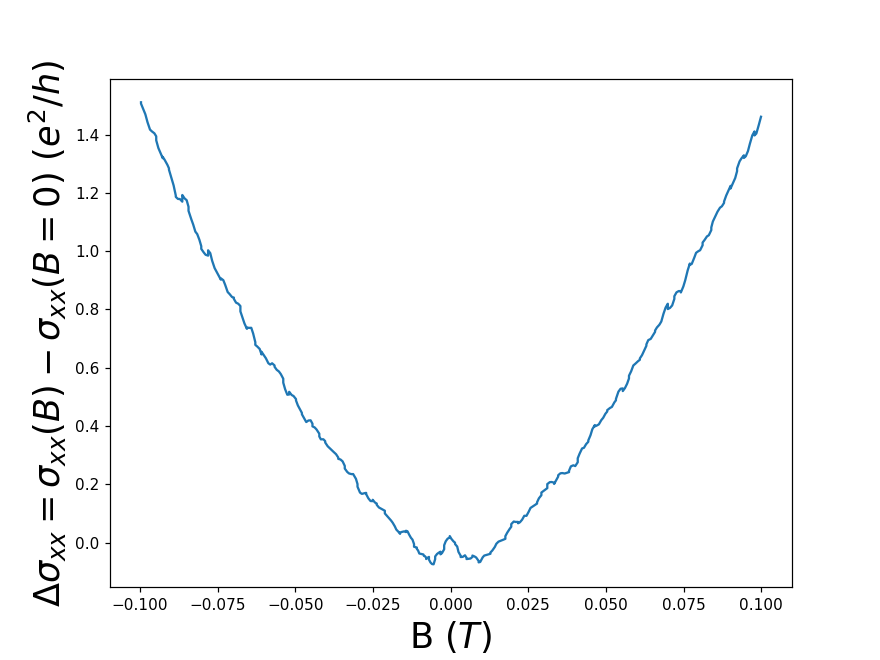

In [166]:
sigma_0 = carrierdensity*e*mobility
resistivity_background = (1.0 + (mobility*xdata)**2)/sigma_0 #parabolic background resistivity
delta_res = resistivity[xmask] - resistivity_background #subtraction of background resistivity
delta_cond = (-1.0*delta_res*sigma_0*sigma_0) #coversion of delta_res to conductivity
#ydata = conductivity[xmask]/(e**2/h)-62.713
fig, ax1 = mpl.subplots(figsize=(8, 6))
ax1.set_xlabel('B ($T$)', fontsize = 23)
ax1.set_ylabel(r'$\Delta\sigma_{xx} = \sigma_{xx}(B) - \sigma_{xx}(B=0)$ ($e^2/h$)', fontsize=23)
ydata = (delta_cond - 0.000218)/(e**2/h) #subtraction of zerofield conductance 
mpl.plot(xdata, ydata)
mpl.show()

## Perform fitting below

In [149]:
#Fit for the parameters a, b of the function func:

popt, pcov = curve_fit(func, xdata, ydata, bounds = (0, [1., 1.]))
popt

array([ 0.52620899,  0.44730659])

## Plot fitted function

<IPython.core.display.Javascript object>


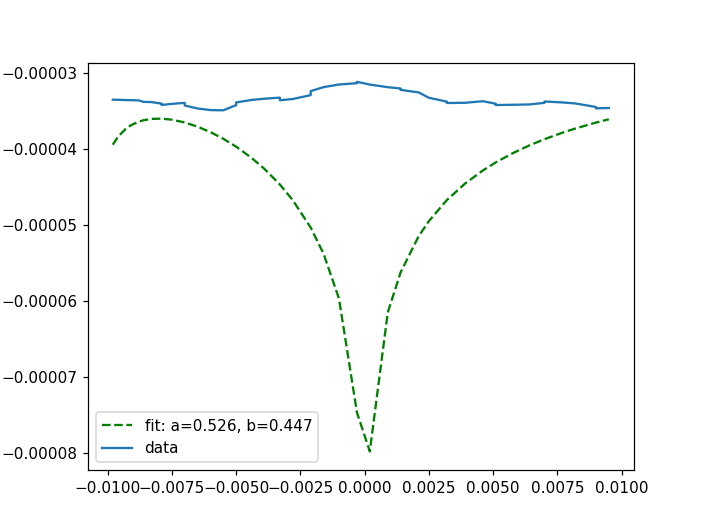

In [150]:
f, ax = mpl.subplots()

ax.plot(xdata, func(xdata, *popt), 'g--', label='fit: a=%5.3f, b=%5.3f' % tuple(popt))      
ax.plot(xdata, ydata, label = 'data')

ax.legend()

mpl.show()

In [80]:
from scipy import special
scipy.special.digamma(0.51/.05 - 1.0/2.0)

2.2196947535188634

In [81]:
sumOfSeries1(50, 0.05, 0.51)

2.7243090262961016